## Setup

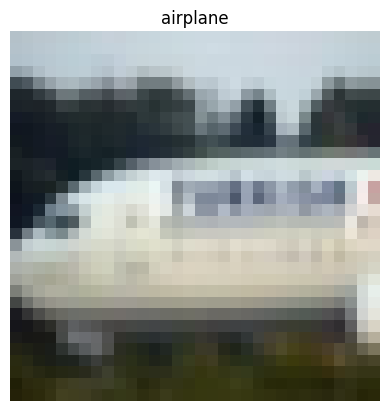

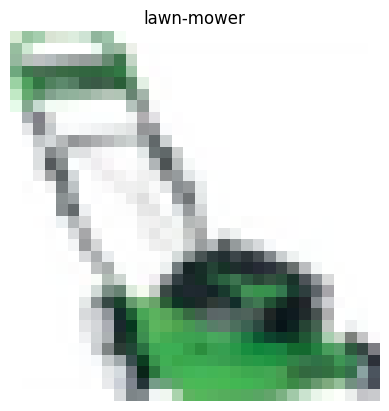

['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium fish', 'flatfish', 'ray', 'shark', 'trout', 'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 'bottles', 'bowls', 'cans', 'cups', 'plates', 'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf', 'bridge', 'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab', 'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 'woman', 'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 'maple', 'oak', 'palm', 'pine', 'willow', 'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 'lawn-mower', 'rocket', 'stree

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from cifar import load_cifar10_data, split_into_classes, get_class_indexes, load_data
import cifar
import random

from GEM.args import *
from torch.nn.functional import relu, avg_pool2d
import torch.nn as nn
import quadprog

# GEM UTILS
from Memorization.GEM import *

AGEM = False
PRETRAIN = 0 # number of initial classes to pretrain on
# Globals 
DATASET = 'cifar-100'
DATASET_PATH = 'cifar-100-python' 
CLASSES = cifar.CLASSES
SHUFFLEDCLASSES = CLASSES.copy()
CONFIDENCE_SAMPLES = 5
if DATASET == 'cifar-10':
    CLASSES = cifar.CLASSES
    SHUFFLEDCLASSES = CLASSES.copy()
elif DATASET == 'cifar-100':
    CLASSES = cifar.CLASSES_100_UNORDERED
    SHUFFLEDCLASSES = CLASSES.copy()
print(CLASSES)

## Memorization Metrics

In [2]:
mem_data = np.load("Memorization/cifar100_mem.npz")  # Replace with actual file path
mem_scores = mem_data["tr_mem"]  

## New GEM

In [3]:
def compute_offsets(task, nc_per_task, is_cifar):
    """
        Compute offsets for cifar to determine which
        outputs to select for a given task.
    """
    val1 = max(PRETRAIN - nc_per_task, 0)
    val2 = max(PRETRAIN - nc_per_task, 0)
    if task == 0:
        val1 = 0
        val2 = max(PRETRAIN - nc_per_task, 0)
    offset1 = task * nc_per_task + val1
    offset2 = (task + 1) * nc_per_task + val2    
    return offset1, offset2


def store_grad(pp, grads, grad_dims, tid):
    """
        This stores parameter gradients of past tasks.
        pp: parameters
        grads: gradients
        grad_dims: list with number of parameters per layers
        tid: task id
    """
    # store the gradients
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1


def overwrite_grad(pp, newgrad, grad_dims):
    """
        This is used to overwrite the gradients with a new gradient
        vector, whenever violations occur.
        pp: parameters
        newgrad: corrected gradient
        grad_dims: list storing number of parameters at each layer
    """
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1


def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    """
        Solves the GEM dual QP described in the paper given a proposed
        gradient "gradient", and a memory of task gradients "memories".
        Overwrites "gradient" with the final projected update.

        input:  gradient, p-vector
        input:  memories, (t * p)-vector
        output: x, p-vector
    """
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))

def agemprojection(gradient, gradient_memory, margin=0.5, eps=1e-5):
    """
    Projection of gradients for A-GEM with the memory approach
    Use averaged gradient memory for projection
    
    input:  gradient, g-reference
    output: gradient, g-projected
    """

    gref = gradient_memory.t().double().mean(axis=0).cuda() # * margin
    g = gradient.contiguous().view(-1).double().cuda()

    dot_prod = torch.dot(g, gref)
    
    #if dot_prod < 0:
    #    x = g
    #    gradient.copy_(torch.Tensor(x).view(-1, 1))
    #    return
    
    # avoid division by zero
    dot_prod = dot_prod/(torch.dot(gref, gref))
    
    # epsvector = torch.Tensor([eps]).cuda()
    
    x = g*0.5 + gref * abs(dot_prod)  # + epsvector
    gradient.copy_(torch.Tensor(x).view(-1, 1))
    
def replay(gradient, gradient_memory):
    """
    Adds the gradients of the current task to the memory 
    
    input:  gradient, g-reference
    output: gradient, g-projected
    """
    g = gradient_memory.t().double().sum(axis=0).cuda()
    gref = gradient.contiguous().view(-1).double().cuda()
    # simply add the gradients
    x = g + gref
    gradient.copy_(torch.Tensor(x).view(-1, 1))
    
def naiveretraining(gradient):
    """
    Naive retraining of the model on the current task
    
    input:  gradient, g-reference
    output: gradient, g-projected
    """
    g = gradient.t().double().mean(axis=0).cuda()
    gradient.copy_(torch.Tensor(g).view(-1, 1))

# --- Modified GEM Model Class with Selective Memory Update ---

class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_tasks, args):
        super(Net, self).__init__()
        nl, nh = args.n_layers, args.n_hiddens
        self.margin = args.memory_strength
        self.net = ResNet18(n_outputs)  # Assume ResNet18 is defined elsewhere
        self.ce = nn.CrossEntropyLoss()
        self.n_outputs = n_outputs
        self.opt = torch.optim.SGD(self.parameters(), args.lr)
        self.n_memories = args.n_memories
        self.gpu = args.cuda

        # Allocate episodic memory buffers
        self.memory_data = torch.FloatTensor(n_tasks, self.n_memories, n_inputs)
        self.memory_labs = torch.LongTensor(n_tasks, self.n_memories)
        if args.cuda:
            self.memory_data = self.memory_data.cuda()
            self.memory_labs = self.memory_labs.cuda()

        # Allocate temporary gradient memory
        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.Tensor(sum(self.grad_dims), n_tasks)
        if args.cuda:
            self.grads = self.grads.cuda()

        # Counters and task bookkeeping
        self.observed_tasks = []
        self.old_task = -1
        self.mem_cnt = 0
        minus = 1 if PRETRAIN > 0 else 0
        self.nc_per_task = int((n_outputs - PRETRAIN) / (n_tasks - minus))
        self.is_cifar = True  # Assumed to be true for CIFAR experiments

    def forward(self, x, t):
        output = self.net(x)
        if t == -1:
            return output
        # Mask outputs not corresponding to the current task.
        val1 = 0
        val2 = 0
        if t != 0:
            val1 = max(PRETRAIN - self.nc_per_task, 0)
            val2 = val1
        else:
            val1 = 0
            val2 = max(PRETRAIN - self.nc_per_task, 0)                                                 
        offset1 = int(t * self.nc_per_task + val1)
        offset2 = int((t + 1) * self.nc_per_task + val2) 
        if offset1 > 0:
            output[:, :offset1].data.fill_(-10e10)
        if offset2 < self.n_outputs:
            output[:, offset2:self.n_outputs].data.fill_(-10e10)
        return output

    def observe(self, algorithm, x, t, y):
        # update memory
        if t != self.old_task:
            self.observed_tasks.append(t)
            self.old_task = t
            
        val = 0
        if t == 0:
            val = max(PRETRAIN,1)
        else:
            val = 1
        # Update ring buffer storing examples from current task
        bsz = y.data.size(0)
        if (algorithm == 'NAIVE'):
            self.zero_grad()
            loss = self.ce(self.forward(x, t), y)
            loss.backward()
            self.opt.step()
            return
        
        endcnt = min(self.mem_cnt + bsz, self.n_memories) #256
        effbsz = endcnt - self.mem_cnt # 256
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0

        # compute gradient on previous tasks
        # if PRETRAIN == 0:
        #     val = 1
        # else:
        #     val = 0
        if len(self.observed_tasks) > 0: ### CHANGED FROM 1 to 0 SINCE WE PRETRAIN ON FST 5 CLASSES 
            for tt in range(len(self.observed_tasks) -1): ### CHANGED FROM -1 to -0 SINCE WE PRETRAIN ON FST 5 CLASSES 
                self.zero_grad()
                # fwd/bwd on the examples in the memory
                past_task = self.observed_tasks[tt]
                
                offset1, offset2 = compute_offsets(past_task, self.nc_per_task,
                                                   self.is_cifar)
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)

        # now compute the grad on the current minibatch
        self.zero_grad()

        offset1, offset2 = compute_offsets(t, self.nc_per_task, self.is_cifar) 
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        # check if gradient violates constraints
        if len(self.observed_tasks) > 0: ### CHANGED FROM 1 to 0 SINCE WE PRETRAIN ON FST 5 CLASSES 
            if algorithm == 'AGEM':
                store_grad(self.parameters, self.grads, self.grad_dims, t)
                indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                    else torch.LongTensor(self.observed_tasks[:-1])
                dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                                self.grads.index_select(1, indx))
                if (dotp < 0).sum() != 0:
                    agemprojection(self.grads[:, t].unsqueeze(1), self.grads.index_select(1, indx), self.margin)
                    # copy gradients back
                    overwrite_grad(self.parameters, self.grads[:, t],
                                self.grad_dims)
            # copy gradient
            elif algorithm == 'GEM':
                store_grad(self.parameters, self.grads, self.grad_dims, t)
                indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                    else torch.LongTensor(self.observed_tasks[:-1])
                dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                                self.grads.index_select(1, indx))
                if (dotp < 0).sum() != 0:
                    project2cone2(self.grads[:, t].unsqueeze(1),
                                self.grads.index_select(1, indx), self.margin)
                    # copy gradients back
                    overwrite_grad(self.parameters, self.grads[:, t],
                                self.grad_dims)
            elif algorithm == 'REPLAY':
                store_grad(self.parameters, self.grads, self.grad_dims, t)
                indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                    else torch.LongTensor(self.observed_tasks[:-1])
                replay(self.grads[:, t].unsqueeze(1), self.grads.index_select(1, indx))
                # copy gradients back
                overwrite_grad(self.parameters, self.grads[:, t],
                            self.grad_dims)
        self.opt.step()


    def update_memory_from_dataset(self, x_all, y_all, t, t_mapping, mem_scores, split, criteria_params):
        """
        Update the episodic memory for task t using the entire training set for that task.
        Computes the memorization score for each example and selects the top (or bottom)
        self.n_memories examples based on the "selection" criteria.
        
        If criteria_params is not a dict (e.g. a string "GEM"), this function does nothing.
        """
        # Only perform global update if criteria_params is a dict.
        if not isinstance(criteria_params, dict):
            return
        
        task_orig_indices = []
        classes_in_task = t_mapping[t]
        for cls in classes_in_task:
            # Append indices for this class.
            task_orig_indices.extend(mem_data[f"tr_classidx_{cls}"])
        task_orig_indices = task_orig_indices[:len(x_all)]
        task_orig_indices = np.array(task_orig_indices)

        mem_scores = torch.tensor(mem_scores[task_orig_indices])
        N = mem_scores.size(0)
        
        selection_mode = criteria_params.get("selection", "most")
        
        # Sort indices by memorization score.
        if selection_mode == "most":
            _, sorted_indices = torch.sort(mem_scores, descending=True)
        elif selection_mode == "least":
            _, sorted_indices = torch.sort(mem_scores, descending=False)
        else:
            arr = [i for i in range(len(mem_scores))]
            random.shuffle(arr)
            sorted_indices = torch.tensor(arr)

        arr = [i for i in range(len(mem_scores))]
        random.shuffle(arr)
        torch.tensor(arr)
        
        num_to_select = min(self.n_memories, N)

        if split > 1 or split < 0:
            raise ValueError("split must be in the range [0,1]")

        mem_selection = round(num_to_select * split)

        selected_indices = sorted_indices[:mem_selection].tolist()
        selected_indices = arr[:(num_to_select-mem_selection)] + selected_indices
        random.shuffle(selected_indices)
        
        # Update the memory for task t with the selected examples.
        self.memory_data[t, :num_to_select].copy_(x_all[selected_indices])
        self.memory_labs[t, :num_to_select].copy_(y_all[selected_indices])
        self.mem_cnt = num_to_select  # update the pointer for task t

## RUN

In [4]:
N_TASKS = 20  # [2 tasks [airplane, automobile, etc], [dog, frog, etc]]
SIZE_OF_TASKS = 5
N_OUTPUTS = 100
N_INPUTS = 32 * 32 * 3

def run_cifar(criteria_params, args, n_inputs=N_INPUTS, n_outputs=N_OUTPUTS, 
                        n_tasks=N_TASKS, size_of_task=SIZE_OF_TASKS, newclasses=SHUFFLEDCLASSES, mem_split=0.2):
    # Use the modified GEM model (Net with the new update_memory_from_dataset function)
    model = Net(n_inputs, n_outputs, n_tasks, args)
    if args.cuda:
        model.cuda()
    model.is_cifar = True
    test_bs = 1000
    
    test_accuracies = []

    # Load data (same as before)
    train_data, train_labels, test_data, test_labels = load_data(DATASET_PATH, DATASET)
    NEWCLASSES = newclasses
    print("new ordering of classes: ", NEWCLASSES)
    oldClasstoNewClass = {}
    for i in range(len(CLASSES)):
        oldClasstoNewClass[i] = NEWCLASSES.index(CLASSES[i])
    for i in range(len(train_labels)):
        train_labels[i] = oldClasstoNewClass[train_labels[i]]
    for i in range(len(test_labels)):
        test_labels[i] = oldClasstoNewClass[test_labels[i]]

    new_classes = [None] * len(CLASSES)
    for original_class, new_index in oldClasstoNewClass.items():
        new_classes[new_index] = original_class
    
    # Create a dictionary that maps each task number to the ordered list of classes for that task.
    task_mapping = {}
    total_classes = len(new_classes)
    classes_per_task = total_classes // n_tasks
    remainder = total_classes % n_tasks

    start_idx = 0
    for task in range(n_tasks):
        # Distribute the remainder: the first 'remainder' tasks get one extra class.
        extra = 1 if task < remainder else 0
        end_idx = start_idx + classes_per_task + extra
        task_mapping[task] = new_classes[start_idx:end_idx]
        start_idx = end_idx
    

    pretrain_classses = NEWCLASSES[:PRETRAIN]
    pretrain_data, pretrain_labels = split_into_classes(train_data, train_labels, pretrain_classses, NEWCLASSES)
    pretest_data, pretest_labels = split_into_classes(test_data, test_labels, pretrain_classses, NEWCLASSES)
    tasks = []
    tests = []
    if PRETRAIN > 0:
        tasks = [[pretrain_data, pretrain_labels]]
        tests = [pretest_data, pretest_labels]
    else:
        tasks = []
        tests = []
    for i in range(n_tasks):
        if i == 0 and PRETRAIN > 0:
            continue
        elif PRETRAIN > 0:
            task_data, task_labels = split_into_classes(train_data, train_labels, 
                                                        NEWCLASSES[PRETRAIN + size_of_task*(i-1) : PRETRAIN + size_of_task*i], 
                                                        NEWCLASSES)
            tasks.append([task_data, task_labels])
            partition_test_data, partition_test_labels = split_into_classes(test_data, test_labels, 
                                                        NEWCLASSES[PRETRAIN + size_of_task*(i-1) : PRETRAIN + size_of_task*i], 
                                                        NEWCLASSES)
            tests.append(partition_test_data)
            tests.append(partition_test_labels)
        else:
            task_data, task_labels = split_into_classes(train_data, train_labels, 
                                                        NEWCLASSES[size_of_task*i : size_of_task*(i+1)], NEWCLASSES)
            tasks.append([task_data, task_labels])
            partition_test_data, partition_test_labels = split_into_classes(test_data, test_labels, 
                                                        NEWCLASSES[size_of_task*i : size_of_task*(i+1)], NEWCLASSES)
            tests.append(partition_test_data)
            tests.append(partition_test_labels)

    # Train the model on each task
    for task in range(n_tasks):
        print("Training task:", task + 1)
        # Convert full task training data into tensors
        x = torch.Tensor(tasks[task][0].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(tasks[task][1]).long()
        if args.cuda:
            x, y = x.cuda(), y.cuda()

        max_idx = 0
    
        # Per-batch training using observe()
        for epoch in range(args.n_epochs):
            for j in range(0, len(tasks[task][0]), args.batch_size):
                current_data = x[j: j + args.batch_size]
                current_labels = y[j: j + args.batch_size]
                model.train()
                model.observe('GEM', current_data, task, current_labels)
                max_idx += args.batch_size
            
            # Optional: early stopping if training accuracy exceeds 75%
            correct = 0
            total = len(tasks[task][0])
            for j in range(0, len(tasks[task][0]), test_bs):
                current_data = x[j: j + test_bs]
                current_labels = y[j: j + test_bs]
                output = model.forward(current_data, task)
                pred = output.data.max(1)[1]
                correct += (pred == current_labels).sum().item()
            if correct / total > 0.75:
                break
        
        # *** Global Memory Update Step ***
        # After training on the task, update the replay buffer using the entire training set.
        print("Updating memory for task", task + 1, "using global selection.")
        model.update_memory_from_dataset(x[:max_idx], y[:max_idx], task, task_mapping, mem_scores, mem_split, criteria_params)
        
        # Testing: Evaluate the model on the test set for this task
        average_confidence = []
        for i in range(0, len(tests), 2):
            correct = 0
            total = len(tests[i])
            x_test = torch.Tensor(tests[i].reshape(-1, 32*32*3)).float()
            y_test = torch.Tensor(tests[i+1]).long()
            if args.cuda:
                x_test, y_test = x_test.cuda(), y_test.cuda()
            model.eval()
            average_confidence_task = []
            for j in range(0, len(tests[i]), test_bs):
                current_data = x_test[j: j + test_bs]
                current_labels = y_test[j: j + test_bs]
                output = model.forward(current_data, i//2)
                probabilities = torch.nn.functional.softmax(output, dim=1)
                predicted = torch.max(probabilities, 1).values
                average_confidence_task.append(torch.mean(predicted).item())
                pred = output.data.max(1)[1]
                correct += (pred == current_labels).sum().item()
            test_accuracies.append(correct / total)
            average_confidence.append(sum(average_confidence_task) / len(average_confidence_task))  
    
    return model, test_accuracies, average_confidence


def shuffle_classes(classes, dataset):
    if dataset == 'cifar-10':
        return random.shuffle(classes)
    elif dataset == 'cifar-100':
        shuffled_classes = []
        partitions = [classes[i:i + SIZE_OF_TASKS] for i in range(0, len(classes), SIZE_OF_TASKS)]
        random.shuffle(partitions)
        for partition in partitions:
            shuffled_classes.extend(partition)
        return shuffled_classes
    else:
        return classes  # No shuffling for other datasets
    

def plot_task_accuracies(test_accuracies, num_tasks):
    for t in range(num_tasks):
        # Calculate the indices for the current set of accuracies
        start_idx = t * num_tasks
        end_idx = start_idx + num_tasks
        # Extract accuracies for all tasks after training task t+1
        print (test_accuracies)
        accuracies = test_accuracies[start_idx:end_idx]
        # Create labels for the tasks
        task_labels = [f'{i+1}' for i in range(num_tasks)]
        # Plot the accuracies
        plt.bar(task_labels, [acc * 100 for acc in accuracies])

        # Calculate the y-value for the horizontal line
        y_value = 100 / SIZE_OF_TASKS  # or use SIZE_OF_TASKS if it's defined separately

        # Add horizontal line across the bar chart
        plt.axhline(y=y_value, color='red', linestyle='--', label=f'y = {y_value:.2f}')
        
        plt.title(f'Test Set Accuracy for All Tasks (Post Task {t+1} Training)')
        plt.ylabel('Accuracy (%)')
        plt.xlabel('Task')
        plt.legend()
        plt.show()

def plot_comparison_accuracies(accuracies_list, num_tasks, num_models, model_names):
    bar_width = 0.2
    index = np.arange(num_tasks)
    
    for i, accuracies in enumerate(accuracies_list):
        start_idx = (num_tasks-1) * num_tasks
        end_idx = start_idx + num_tasks 
        print(start_idx, end_idx)
        plt.bar(index + i * bar_width, [acc * 100 for acc in accuracies[start_idx:end_idx]], bar_width, label=model_names[i])
    
    plt.xlabel('Tasks')
    plt.ylabel('Accuracy (%)')
    plt.title('Comparison of Test Set Accuracies for All Models')
    plt.xticks(index + bar_width * (num_models - 1) / 2, [f'{i+1}' for i in range(num_tasks)])
    plt.legend()
    plt.gcf().set_size_inches(10, 5)
    plt.savefig("Memorization/results/comparison_accuracies.png")
    plt.show()
    

# Example usage:
# plot_comparison_accuracies([average_AGEM_accuracies, average_GEM_accuracies, average_REPLAY_accuracies, average_NAIVE_accuracies], N_TASKS, 4, ['AGEM', 'GEM', 'REPLAY', 'NAIVE'])

## DRIVER CODE

In [5]:
# Number of runs and confidence samples (should be equal)
max_runs = 5
CONFIDENCE_SAMPLES = 5

# Containers for test accuracies and confidences for each GEM variant.
baseline_results = []  # Regular GEM (criteria: "GEM")
most_results = []      # Selective GEM (criteria: {"selection": "most"})
least_results = []     # Selective GEM (criteria: {"selection": "least"})

baseline_confidences = []
most_confidences = []
least_confidences = []

# Flush CUDA memory if needed.
torch.cuda.empty_cache()

args = Args()


# Loop over runs.
for run in range(max_runs):
    print(f"Run {run+1}")
    random.shuffle(SHUFFLEDCLASSES)  # Shuffle class order as needed.
    
    # # --- Baseline: Regular GEM ---
    # model_b, test_acc_b, conf_b = run_cifar("GEM", Args())
    # print("Baseline GEM test accuracies:", test_acc_b)
    # baseline_results.append(test_acc_b)
    # baseline_confidences.append(conf_b)

    # --- Baseline: Regular GEM ---
    model_b, test_acc_b, conf_b = run_cifar({"selection": "abc"}, Args(), mem_split=0.5)
    print("Baseline GEM test accuracies:", test_acc_b)
    baseline_results.append(test_acc_b)
    baseline_confidences.append(conf_b)
    
    # --- Selective GEM Variant: Most Memorized Examples ---
    criteria_most = {"selection": "most"}
    model_m, test_acc_m, conf_m = run_cifar(criteria_most, Args(), mem_split=0.5)
    print("Selective GEM (Most Memorized) test accuracies:", test_acc_m)
    most_results.append(test_acc_m)
    most_confidences.append(conf_m)
    
    # --- Selective GEM Variant: Least Memorized Examples ---
    criteria_least = {"selection": "least"}
    model_l, test_acc_l, conf_l = run_cifar(criteria_least, Args(), mem_split=0.5)
    print("Selective GEM (Least Memorized) test accuracies:", test_acc_l)
    least_results.append(test_acc_l)
    least_confidences.append(conf_l)

Run 1
new ordering of classes:  ['turtle', 'cloud', 'train', 'bear', 'lamp', 'butterfly', 'woman', 'snail', 'forest', 'shrew', 'wardrobe', 'skyscraper', 'elephant', 'bee', 'bus', 'plates', 'dinosaur', 'telephone', 'sea', 'couch', 'porcupine', 'oranges', 'camel', 'pickup truck', 'pears', 'bottles', 'tank', 'flatfish', 'tractor', 'roses', 'apples', 'bicycle', 'trout', 'clock', 'cans', 'bridge', 'seal', 'otter', 'pine', 'tulips', 'caterpillar', 'squirrel', 'rabbit', 'maple', 'leopard', 'cattle', 'tiger', 'road', 'crab', 'spider', 'palm', 'bowls', 'skunk', 'man', 'computer keyboard', 'ray', 'girl', 'mouse', 'bed', 'lizard', 'lawn-mower', 'motorcycle', 'orchids', 'fox', 'whale', 'chair', 'oak', 'castle', 'cockroach', 'poppies', 'mushrooms', 'hamster', 'cups', 'lion', 'rocket', 'worm', 'beetle', 'lobster', 'chimpanzee', 'house', 'sweet peppers', 'dolphin', 'shark', 'wolf', 'possum', 'table', 'crocodile', 'boy', 'baby', 'beaver', 'aquarium fish', 'mountain', 'sunflowers', 'raccoon', 'kangaroo

/tmp/dcs-tmp.u2110391/ipykernel_1680214/3371310379.py:262: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \


Updating memory for task 1 using global selection.
Training task: 2
Updating memory for task 2 using global selection.
Training task: 3
Updating memory for task 3 using global selection.
Training task: 4
Updating memory for task 4 using global selection.
Training task: 5
Updating memory for task 5 using global selection.
Training task: 6
Updating memory for task 6 using global selection.
Training task: 7
Updating memory for task 7 using global selection.
Training task: 8
Updating memory for task 8 using global selection.
Training task: 9
Updating memory for task 9 using global selection.
Training task: 10
Updating memory for task 10 using global selection.
Training task: 11
Updating memory for task 11 using global selection.
Training task: 12
Updating memory for task 12 using global selection.
Training task: 13
Updating memory for task 13 using global selection.
Training task: 14
Updating memory for task 14 using global selection.
Training task: 15
Updating memory for task 15 using glo

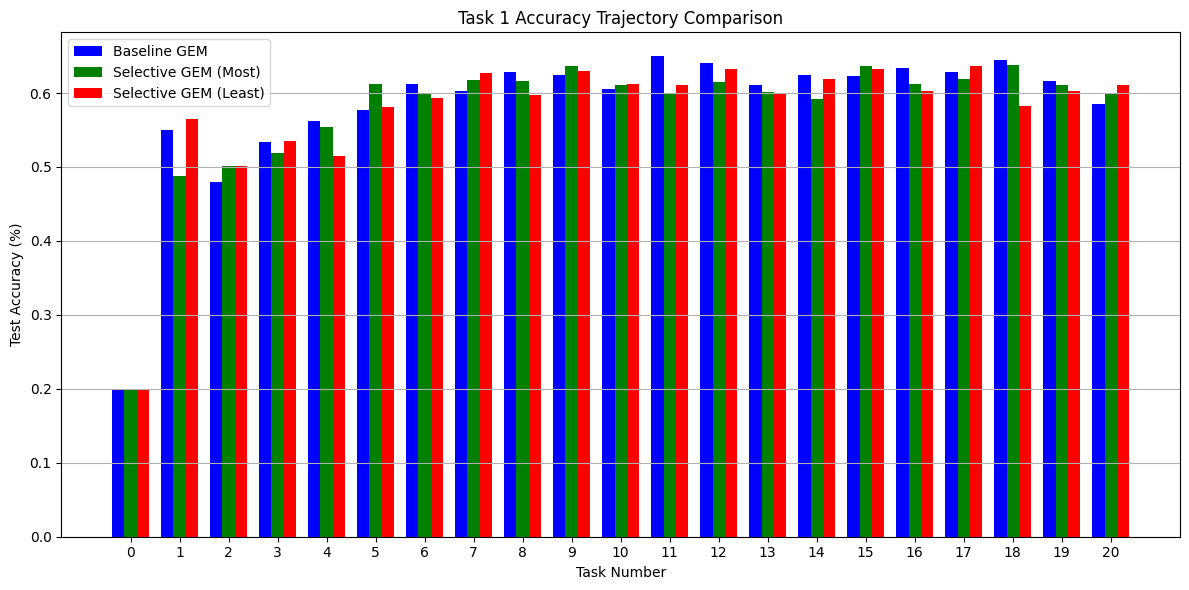

380 400
380 400
380 400


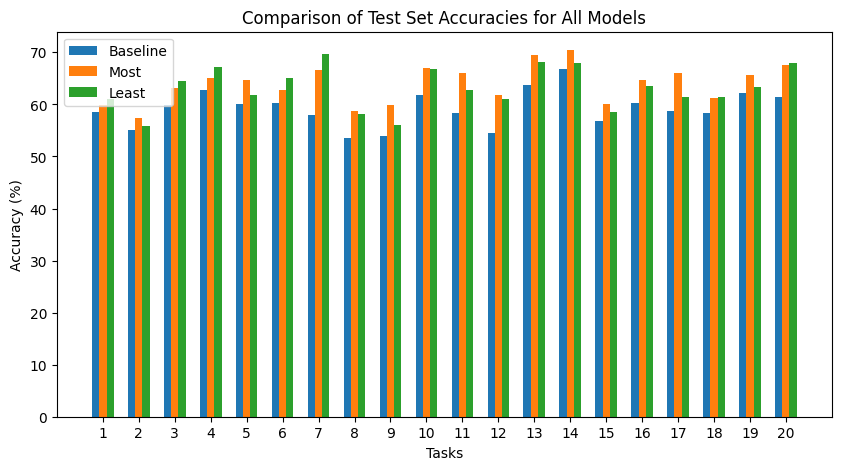

In [6]:
# Compute the average test accuracies over runs.
# Each test accuracy array is assumed to have N_TASKS * N_TASKS (e.g. 400) elements.
average_baseline_accuracies = np.mean(baseline_results, axis=0)
average_most_accuracies     = np.mean(most_results, axis=0)
average_least_accuracies    = np.mean(least_results, axis=0)

# Now extract the trajectory for Task 1.
# In your original code, you start with an initial value (0.2) and then sample every N_TASKS element.
task_1_accuracies_baseline = [0.2]
task_1_accuracies_most     = [0.2]
task_1_accuracies_least    = [0.2]

# Assuming N_TASKS is defined (e.g., 20)
for i in range(0, N_TASKS * N_TASKS, N_TASKS):
    task_1_accuracies_baseline.append(average_baseline_accuracies[i])
    task_1_accuracies_most.append(average_most_accuracies[i])
    task_1_accuracies_least.append(average_least_accuracies[i])

# Plot a grouped bar chart (three bars per task).
n_tasks = len(task_1_accuracies_baseline)  # This will be N_TASKS + 1 because of the initial value.
tasks = np.arange(n_tasks)
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(tasks - bar_width, task_1_accuracies_baseline, width=bar_width, label='Baseline GEM', color='blue')
plt.bar(tasks, task_1_accuracies_most, width=bar_width, label='Selective GEM (Most)', color='green')
plt.bar(tasks + bar_width, task_1_accuracies_least, width=bar_width, label='Selective GEM (Least)', color='red')

plt.xlabel('Task Number')
plt.ylabel('Test Accuracy (%)')
plt.title('Task 1 Accuracy Trajectory Comparison')
plt.xticks(tasks, [str(i) for i in tasks])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

average_baseline_accuracies = np.mean(baseline_results, axis=0)
average_most_accuracies = np.mean(most_results, axis=0)
average_least_accuracies = np.mean(least_results, axis=0)

plot_comparison_accuracies([average_baseline_accuracies, average_most_accuracies, average_least_accuracies], N_TASKS, 3, ['Baseline', 'Most', 'Least'])

## PLOTS

In [7]:
def avg_95_5(sample_accuracies_baseline, sample_accuracies_most, sample_accuracies_least, title, ylabel):
    """
    Computes the average of the last 20 test accuracies for each confidence sample,
    then plots the average along with 95% confidence error bars for each experiment variant.
    """
    averages = []
    maxes = []
    mins = []
    labels = ['Baseline GEM', 'Selective GEM (Most)', 'Selective GEM (Least)']
    
    # Iterate over the three experiment conditions.
    for sample_accuracies in [sample_accuracies_baseline, sample_accuracies_most, sample_accuracies_least]:
        avg_total = 0
        average_list = []
        for j in range(CONFIDENCE_SAMPLES):
            # Assume sample_accuracies[j] is a list/array of test accuracies (e.g. 400 values reshaped as needed)
            last_20 = sample_accuracies[j][-20:]
            avg_val = np.mean(last_20)
            avg_total += avg_val
            average_list.append(avg_val)
        avg_total /= CONFIDENCE_SAMPLES
        averages.append(avg_total)
        maxes.append(np.percentile(average_list, 97.5))
        mins.append(np.percentile(average_list, 2.5))
    
    colors = ['blue', 'green', 'red']
    # Plot the average accuracies with error bars.
    plt.bar(labels, averages,
            yerr=[[averages[i] - mins[i] for i in range(3)], [maxes[i] - averages[i] for i in range(3)]],
            capsize=10, color=colors)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Experiment Variant')
    plt.rcParams["figure.figsize"] = (3, 2)
    plt.grid(axis='y')
    plt.savefig("Memorization/results/" + title + '.png')
    plt.show()


def plot_ECEs(ece_baseline, ece_most, ece_least, title):
    """
    Plots the Expected Calibration Error (ECE) for each experiment variant with 95% confidence error bars.
    """
    colors = ['blue', 'green', 'red']
    labels = ['Baseline GEM', 'Selective GEM (Most)', 'Selective GEM (Least)']
    
    baseline_mean = np.mean(ece_baseline)
    most_mean = np.mean(ece_most)
    least_mean = np.mean(ece_least)
    
    baseline_lower = np.percentile(ece_baseline, 2.5)
    baseline_upper = np.percentile(ece_baseline, 97.5)
    most_lower = np.percentile(ece_most, 2.5)
    most_upper = np.percentile(ece_most, 97.5)
    least_lower = np.percentile(ece_least, 2.5)
    least_upper = np.percentile(ece_least, 97.5)
    
    plt.bar(labels, [baseline_mean, most_mean, least_mean],
            yerr=[[baseline_mean - baseline_lower, most_mean - most_lower, least_mean - least_lower],
                  [baseline_upper - baseline_mean, most_upper - most_mean, least_upper - least_mean]],
            capsize=10, color=colors)
    plt.title(title)
    plt.ylabel('ECE')
    plt.xlabel('Experiment Variant')
    plt.grid(axis='y')
    plt.savefig("Memorization/results/ece.png")
    plt.show()


def expected_callibration_error(accuracies, confidences):
    """
    Computes the expected calibration error (ECE) given arrays of accuracies and confidences.
    """
    ece = 0
    for i in range(len(accuracies)):
        ece += abs(accuracies[i] - confidences[i])
    ece /= len(accuracies)
    return ece


def forgetting(sample_accuracies):
    """
    Computes a forgetting measure.
    Assumes sample_accuracies is a 400-element list which is reshaped to (N_TASKS, N_TASKS).
    For each task, we take the maximum accuracy observed across training phases
    and compute the drop in accuracy at the end.
    """
    sample_array = np.array(sample_accuracies).reshape(N_TASKS, N_TASKS)
    max_values = np.amax(sample_array, axis=0)
    
    # Use the final training phase (last row) for all tasks.
    final_accuracies = sample_array[N_TASKS - 1]
    forgetting_measure = [abs(max_values[i] - final_accuracies[i]) for i in range(N_TASKS)]
    return np.mean(forgetting_measure)


def forward_transfer(sample_accuracies):
    """
    Computes the forward transfer. For each task (except the first),
    we measure the difference in test accuracy on that task before and after training on it.
    """
    sample = np.array(sample_accuracies).reshape(N_TASKS, N_TASKS)
    forward_transfers = []
    for i in range(1, N_TASKS):
        forward_transfers.append(sample[i - 1][i] - sample[0][i])
    return np.mean(forward_transfers)


def plot_forward_transfer(sample_accuracies_baseline, sample_accuracies_most, sample_accuracies_least):
    """
    Plots the forward transfer metric for each experiment variant with 95% confidence error bars.
    """
    forward_transfer_baseline = []
    forward_transfer_most = []
    forward_transfer_least = []
    
    for i in range(CONFIDENCE_SAMPLES):
        forward_transfer_baseline.append(forward_transfer(sample_accuracies_baseline[i]))
        forward_transfer_most.append(forward_transfer(sample_accuracies_most[i]))
        forward_transfer_least.append(forward_transfer(sample_accuracies_least[i]))
    
    colors = ['blue', 'green', 'red']
    labels = ['Baseline GEM', 'Selective GEM (Most)', 'Selective GEM (Least)']
    
    baseline_mean = np.mean(forward_transfer_baseline)
    most_mean = np.mean(forward_transfer_most)
    least_mean = np.mean(forward_transfer_least)
    
    baseline_lower = np.percentile(forward_transfer_baseline, 2.5)
    baseline_upper = np.percentile(forward_transfer_baseline, 97.5)
    most_lower = np.percentile(forward_transfer_most, 2.5)
    most_upper = np.percentile(forward_transfer_most, 97.5)
    least_lower = np.percentile(forward_transfer_least, 2.5)
    least_upper = np.percentile(forward_transfer_least, 97.5)
    
    plt.bar(labels, [baseline_mean, most_mean, least_mean],
            yerr=[[baseline_mean - baseline_lower, most_mean - most_lower, least_mean - least_lower],
                  [baseline_upper - baseline_mean, most_upper - most_mean, least_upper - least_mean]],
            capsize=10, color=colors)
    plt.title('Forward Transfer')
    plt.ylabel('Forward Transfer')
    plt.xlabel('Experiment Variant')
    plt.grid(axis='y')
    plt.savefig("Memorization/results/forward_transfer.png")
    plt.show()


def backward_transfer(sample_accuracies):
    """
    Computes the backward transfer for a given experiment condition.
    For each task (except the last), we calculate the drop in test accuracy
    from when that task was trained to after the final task.
    """
    sample = np.array(sample_accuracies).reshape(N_TASKS, N_TASKS)
    backward_transfers = []
    for i in range(N_TASKS - 1):
        backward_transfers.append(sample[N_TASKS - 1][i] - sample[i][i])
    return np.mean(backward_transfers)


def plot_backward_transfer(sample_accuracies_baseline, sample_accuracies_most, sample_accuracies_least):
    """
    Plots the backward transfer metric for each experiment variant with 95% confidence error bars.
    """
    backward_transfer_baseline = []
    backward_transfer_most = []
    backward_transfer_least = []
    
    for i in range(CONFIDENCE_SAMPLES):
        backward_transfer_baseline.append(backward_transfer(sample_accuracies_baseline[i]))
        backward_transfer_most.append(backward_transfer(sample_accuracies_most[i]))
        backward_transfer_least.append(backward_transfer(sample_accuracies_least[i]))
    
    colors = ['blue', 'green', 'red']
    labels = ['Baseline GEM', 'Selective GEM (Most)', 'Selective GEM (Least)']
    
    baseline_mean = np.mean(backward_transfer_baseline)
    most_mean = np.mean(backward_transfer_most)
    least_mean = np.mean(backward_transfer_least)
    
    baseline_lower = np.percentile(backward_transfer_baseline, 2.5)
    baseline_upper = np.percentile(backward_transfer_baseline, 97.5)
    most_lower = np.percentile(backward_transfer_most, 2.5)
    most_upper = np.percentile(backward_transfer_most, 97.5)
    least_lower = np.percentile(backward_transfer_least, 2.5)
    least_upper = np.percentile(backward_transfer_least, 97.5)
    
    plt.bar(labels, [baseline_mean, most_mean, least_mean],
            yerr=[[baseline_mean - baseline_lower, most_mean - most_lower, least_mean - least_lower],
                  [baseline_upper - baseline_mean, most_upper - most_mean, least_upper - least_mean]],
            capsize=10, color=colors)
    plt.title('Backward Transfer')
    plt.ylabel('Backward Transfer')
    plt.xlabel('Experiment Variant')
    plt.grid(axis='y')
    plt.savefig("Memorization/results/backward_transfer.png")
    plt.show()


def plot_forgetting(sample_accuracies_baseline, sample_accuracies_most, sample_accuracies_least, title):
    """
    Plots the forgetting measure for each experiment variant with 95% confidence error bars.
    """
    forgetting_baseline = []
    forgetting_most = []
    forgetting_least = []
    
    for i in range(CONFIDENCE_SAMPLES):
        forgetting_baseline.append(forgetting(sample_accuracies_baseline[i]))
        forgetting_most.append(forgetting(sample_accuracies_most[i]))
        forgetting_least.append(forgetting(sample_accuracies_least[i]))
    
    colors = ['blue', 'green', 'red']
    labels = ['Baseline GEM', 'Selective GEM (Most)', 'Selective GEM (Least)']
    
    baseline_mean = np.mean(forgetting_baseline)
    most_mean = np.mean(forgetting_most)
    least_mean = np.mean(forgetting_least)
    
    baseline_lower = np.percentile(forgetting_baseline, 2.5)
    baseline_upper = np.percentile(forgetting_baseline, 97.5)
    most_lower = np.percentile(forgetting_most, 2.5)
    most_upper = np.percentile(forgetting_most, 97.5)
    least_lower = np.percentile(forgetting_least, 2.5)
    least_upper = np.percentile(forgetting_least, 97.5)
    
    plt.bar(labels, [baseline_mean, most_mean, least_mean],
            yerr=[[baseline_mean - baseline_lower, most_mean - most_lower, least_mean - least_lower],
                  [baseline_upper - baseline_mean, most_upper - most_mean, least_upper - least_mean]],
            capsize=10, color=colors)
    plt.title(title)
    plt.ylabel('Forgetting Measure')
    plt.xlabel('Experiment Variant')
    plt.grid(axis='y')
    plt.savefig("Memorization/results/forgetting.png")
    plt.show()

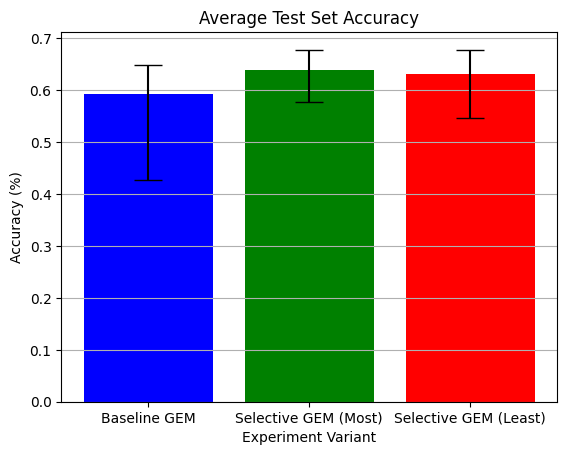

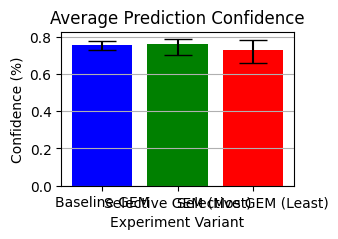

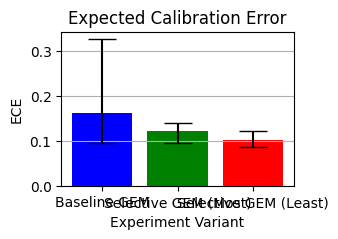

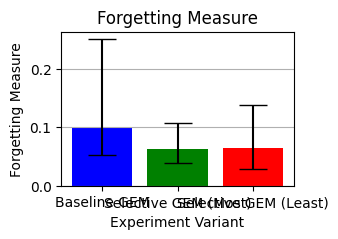

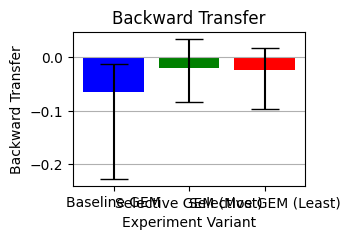

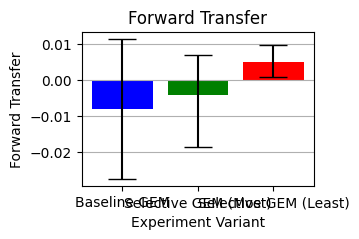

In [8]:
for i in range(int(max_runs / CONFIDENCE_SAMPLES)):
    # Extract the accuracies for the current sample for each variant.
    sample_baseline_accuracies = baseline_results[i*CONFIDENCE_SAMPLES : (i+1)*CONFIDENCE_SAMPLES]
    sample_most_accuracies     = most_results[i*CONFIDENCE_SAMPLES : (i+1)*CONFIDENCE_SAMPLES]
    sample_least_accuracies    = least_results[i*CONFIDENCE_SAMPLES : (i+1)*CONFIDENCE_SAMPLES]
    
    # Plot the average of the last 20 accuracies for each confidence sample.
    avg_95_5(sample_baseline_accuracies, sample_most_accuracies, sample_least_accuracies, 
             'Average Test Set Accuracy', 'Accuracy (%)')
    
    # Extract the prediction confidences for the current sample.
    sample_baseline_confidences = baseline_confidences[i*CONFIDENCE_SAMPLES : (i+1)*CONFIDENCE_SAMPLES]
    sample_most_confidences     = most_confidences[i*CONFIDENCE_SAMPLES : (i+1)*CONFIDENCE_SAMPLES]
    sample_least_confidences    = least_confidences[i*CONFIDENCE_SAMPLES : (i+1)*CONFIDENCE_SAMPLES]
    
    avg_95_5(sample_baseline_confidences, sample_most_confidences, sample_least_confidences, 
             'Average Prediction Confidence', 'Confidence (%)')
    
    # Calculate Expected Calibration Error (ECE) for each confidence sample.
    ece_baseline = []
    ece_most     = []
    ece_least    = []
    for j in range(CONFIDENCE_SAMPLES):
        # We use the last N_TASKS test accuracies from each confidence sample.
        ece_baseline.append(expected_callibration_error(sample_baseline_accuracies[j][-N_TASKS:], 
                                                        sample_baseline_confidences[j]))
        ece_most.append(expected_callibration_error(sample_most_accuracies[j][-N_TASKS:], 
                                                    sample_most_confidences[j]))
        ece_least.append(expected_callibration_error(sample_least_accuracies[j][-N_TASKS:], 
                                                     sample_least_confidences[j]))
    plot_ECEs(ece_baseline, ece_most, ece_least, 'Expected Calibration Error')
    
    # Plot forgetting measure.
    plot_forgetting(sample_baseline_accuracies, sample_most_accuracies, sample_least_accuracies, 
                    'Forgetting Measure')
    
    # Plot backward transfer.
    plot_backward_transfer(sample_baseline_accuracies, sample_most_accuracies, sample_least_accuracies)
    
    # Plot forward transfer.
    plot_forward_transfer(sample_baseline_accuracies, sample_most_accuracies, sample_least_accuracies)

In [9]:
import scipy.stats as stats
# Convert the lists to a numpy array where each row is a run:
# Columns: 0 -> baseline, 1 -> most memorized, 2 -> least memorized
data_matrix = np.column_stack([baseline_results, most_results, least_results])

# Run the Friedman test:
statistic, p_value = stats.friedmanchisquare(data_matrix[:, 0],
                                             data_matrix[:, 1],
                                             data_matrix[:, 2])
print("Friedman test statistic:", statistic)
print("Friedman test p-value:", p_value)

Friedman test statistic: 7.6000000000000085
Friedman test p-value: 0.0223707718561655


In [10]:
# Compare Baseline vs. Most Memorized
stat_most, p_value_most = stats.wilcoxon(average_baseline_accuracies, average_most_accuracies)
# Compare Baseline vs. Least Memorized
stat_least, p_value_least = stats.wilcoxon(average_baseline_accuracies, average_least_accuracies)

stat_a, p_value_a = stats.wilcoxon(average_most_accuracies, average_least_accuracies)

print("Baseline vs. Most Memorized:")
print("Wilcoxon test statistic:", stat_most)
print("p-value:", p_value_most)

print("\nBaseline vs. Least Memorized:")
print("Wilcoxon test statistic:", stat_least)
print("p-value:", p_value_least)

print("\nMost vs. Least Memorized:")
print("Wilcoxon test statistic:", stat_a)
print("p-value:", p_value_a)


Baseline vs. Most Memorized:
Wilcoxon test statistic: 39896.5
p-value: 0.9299137259915202

Baseline vs. Least Memorized:
Wilcoxon test statistic: 39530.5
p-value: 0.805573968458452

Most vs. Least Memorized:
Wilcoxon test statistic: 39832.5
p-value: 0.9766386099569636
